### Numerical optimization, CasADi

#### Minimization

In [47]:
import casadi as cs

# Declare variables
x = cs.MX.sym("x", 2)

# Form the NLP
f = x[0]**2 + 3 * x[1]**2 # objective
g = x[0]+x[1] + 12    # constraint >= lbg
#g = x[0] - 3 # >= 0

########
# x = (6, 6)^T
# f = 36 + 36 = 72
# g = 6 + 6 = 12
#
########

nlp = {'x' : x, 'f' : f, 'g' : g}
#nlp = {'x' : x, 'f' : f}

# Pick an NLP solver
MySolver = "ipopt"
#MySolver = "worhp"
#MySolver = "sqpmethod"

# Solver options
opts = {}
if MySolver=="sqpmethod":
    opts["qpsol"] = "qpoases"
    opts["qpsol_options"] = {"printLevel":"none"}

# Allocate a solver
solver = cs.nlpsol("solver", MySolver, nlp, opts)

# Solve the NLP
sol = solver(lbg=0)

# Print solution
print("-----")
print("objective at solution = ", sol["f"])
print("primal solution = ", sol["x"])
print("dual solution (x) = ", sol["lam_x"])
print("dual solution (g) = ", sol["lam_g"])

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 0.00e+00 6.67e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

#### Simulating dynamical system

In [48]:
import casadi as cs
import matplotlib.pyplot as plt

x = cs.MX.sym('x', 2) # Two states
p = cs.MX.sym('p')   # Free parameter

# Expression for ODE right-hand side
z = 1 - x[1]**2
rhs = cs.vertcat(z * x[0] - x[1] + 2 * cs.tanh(p),
                 x[0])

#\dot{x_0} = (1 - x_1**2) * x_0 - x_1 + 2 * tanh(p)
#\dot{x_1} = x_0

# ODE declaration with free parameter
ode = {'x' : x, 'p' : p, 'ode' : rhs}

# Construct a Function that integrates over 1s
F = cs.integrator('F', 'cvodes', ode, {'tf':1})

# Control vector
u = cs.MX.sym('u', 4, 1)

x = [0, 1]  # Initial state

for k in range(4):
    # Integrate 1s forward in time:
    # call integrator symbolically
    print(x)
    
    res = F(x0 = x, p = u[k])
    x = res["xf"]

print(x)

# NLP declaration
nlp = {'x' : u, 'f' : cs.dot(u,u), 'g' : x}

# Solve using IPOPT
solver = cs.nlpsol('solver','ipopt',nlp)
res = solver(x0=0.2,lbg=0,ubg=0)

[0, 1]
@1=0x0, F([0, 1], 0x1, u[0], 0x1, @1, @1, @1){0}
@1=0x0, F(F([0, 1], 0x1, u[0], 0x1, @1, @1, @1){0}, 0x1, u[1], 0x1, @1, @1, @1){0}
@1=0x0, F(F(F([0, 1], 0x1, u[0], 0x1, @1, @1, @1){0}, 0x1, u[1], 0x1, @1, @1, @1){0}, 0x1, u[2], 0x1, @1, @1, @1){0}
@1=0x0, F(F(F(F([0, 1], 0x1, u[0], 0x1, @1, @1, @1){0}, 0x1, u[1], 0x1, @1, @1, @1){0}, 0x1, u[2], 0x1, @1, @1, @1){0}, 0x1, u[3], 0x1, @1, @1, @1){0}
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total nu

In [49]:
x

MX(@1=0x0, F(F(F(F([0, 1], 0x1, u[0], 0x1, @1, @1, @1){0}, 0x1, u[1], 0x1, @1, @1, @1){0}, 0x1, u[2], 0x1, @1, @1, @1){0}, 0x1, u[3], 0x1, @1, @1, @1){0})

In [50]:
print(res["x"])

[0.268766, 0.497015, 0.371676, 0.0956411]


control found:  [0.268766, 0.497015, 0.371676, 0.0956411]


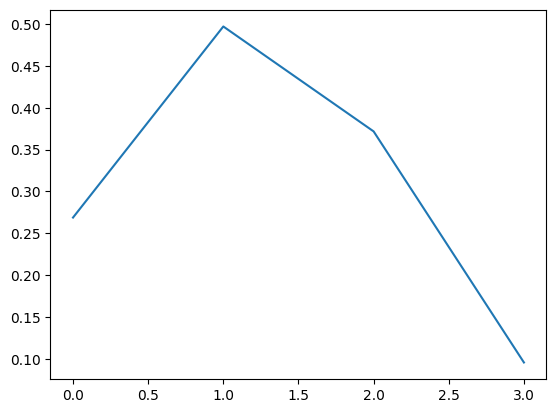

In [51]:
print("control found: ", res["x"])
plt.plot(res["x"])
plt.show()

#### Integrating

$
\vec{x} = 
\begin{pmatrix}
x \\
\dot{x}
\end{pmatrix}
$

$
\dot{\vec{x}}=
\begin{pmatrix}
\dot{x} \\
\frac{p}{m}
\end{pmatrix}
$

In [52]:
x = cs.MX.sym('x', 2) # Two states
p = cs.MX.sym('p')

m = 3

# Expression for ODE right-hand side
rhs = cs.vertcat(x[1],
                 p / m)

#\dot{x_0} = x_1
#\ddot{x_0} = p / m

ode = {}         # ODE declaration
ode['x']   = x   # states
ode['p']   = p
ode['ode'] = rhs # right-hand side

# Construct a Function that integrates over 3s
F = cs.integrator('F', 'cvodes', ode, 0, 3)

# Start from x=[0;1]
res = F(x0 = [0, 2], p = 0)

print(res["xf"])

[6, 2]


#### Simulating system with a determined sequence of controls

In [53]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np

x = cs.MX.sym('x', 2) # Two states
p = cs.MX.sym('p')    # Free parameter

m = 3

rhs = cs.vertcat(x[1],
                 p / m)

ode = {}         # ODE declaration
ode['x']   = x   # states
ode['p']   = p
ode['ode'] = rhs # right-hand side

# Construct a Function that integrates over 1s
F = cs.integrator('F', 'cvodes', ode, {'tf' : 1})

N = 3

# Control vector
#u = cs.MX.sym('u', N, 1)

x = [0, 1]

U = np.array([1, 2, 4])

for k in range(N):
    print("step ", k, ": x = ", x, "u = ", U[k])

    res = F(x0 = x, p = U[k])
    
    x = res["xf"]

print("\nsim complete")
print(res)
print()
print(res['xf'])



step  0 : x =  [0, 1] u =  1
step  1 : x =  [1.16667, 1.33333] u =  2
step  2 : x =  [2.83334, 2] u =  4

sim complete
{'adj_p': DM(0x0), 'adj_u': DM(0x0), 'adj_x0': DM(0x0), 'adj_z0': DM(0x0), 'qf': DM(0x1), 'xf': DM([5.50001, 3.33333]), 'zf': DM(0x1)}

[5.50001, 3.33333]


### Let us simulate LIPM

In [54]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np

def simulate_LIPM(x0, footstep_position, g_over_l, t):
    x = cs.MX.sym('x', 2)
    
    ts = np.linspace(0, t, 10)

    rhs = cs.vertcat(x[1],
                     g_over_l * (x[0] - footstep_position))

    ode = {}
    ode['x'] = x
    ode['ode'] = rhs

    #F = cs.integrator('F', 'cvodes', ode, {'tf' : t})
    F = cs.integrator('F', 'cvodes', ode, {'grid' : ts})

    res = F(x0 = x0)

    x = res["xf"]
    
    return x

[0.43638206 0.5336458  0.60392376 0.65598055 0.69631019 0.72994259
 0.76107346 0.7935857  0.83153465]


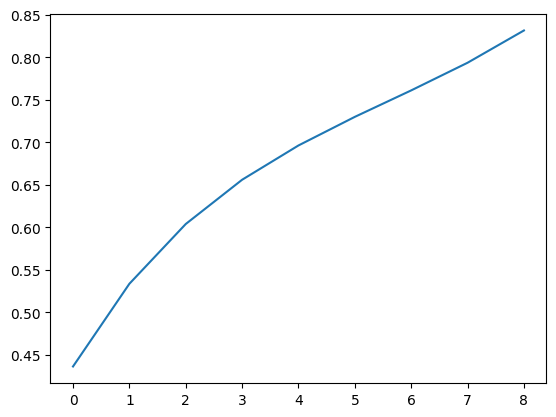

In [63]:
x0 = [0.3, 1.45]

trajectory = simulate_LIPM(x0, 0.75, 10, 1)

npied = np.array(trajectory)[0]

print(npied)

#npied = np.array((x0[0], npied))

#print(npied)

plt.plot(npied)
plt.show()

### And perform MPC "руками"

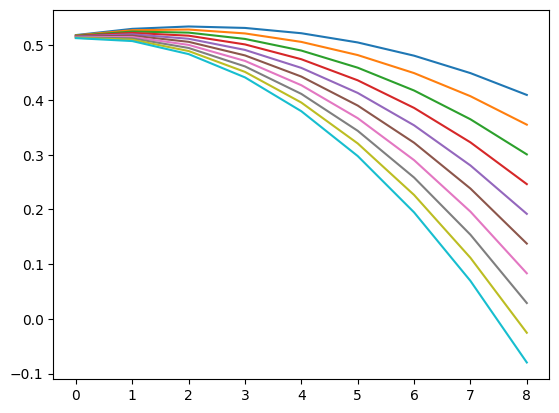

In [64]:
x0 = [0.5, 0.2]

fx = []

for i in range(10):
    trajectory = simulate_LIPM(x0, 1.1 + 0.1 * i, 1, 1)
    
    npied = np.array(trajectory)
    
    plt.plot(npied[0])

plt.show()

### Let us simulate a dynamical point with a given control function by the means of CasADi

x and control over time


/var/folders/kq/s_bn6twd5j1_cd6kqsdz3lg80000gn/T/ipykernel_34868/2231412969.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  control_traj.append(float(u))


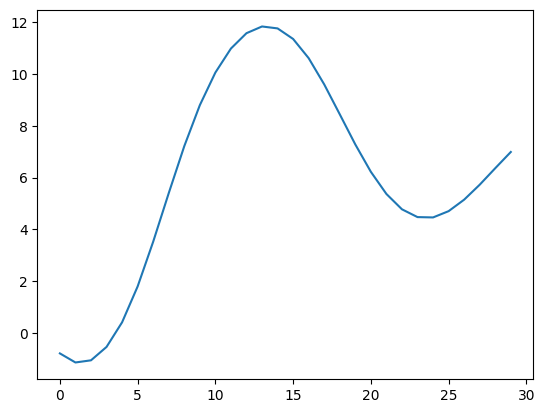

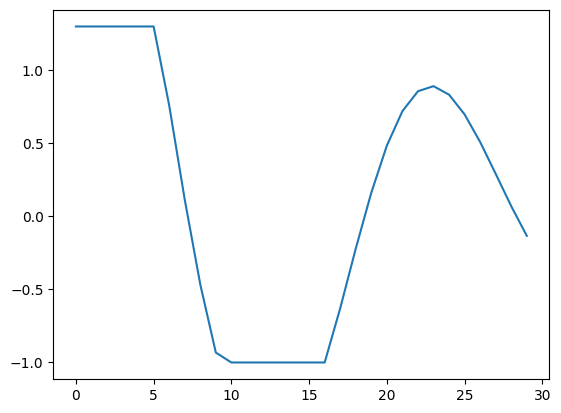

In [ ]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np

def simulate_dyn_point(controller, x0 = [0, 1], step_num = 1300, control_dt = 0.1,
                       m = 3, N = 3, plot = True):
    x = cs.MX.sym('x', 2) # Two states
    p = cs.MX.sym('p')    # Free parameter

    rhs = cs.vertcat(x[1],
                     p / m)

    ode = {}         # ODE declaration
    ode['x']   = x   # states
    ode['p']   = p
    ode['ode'] = rhs # right-hand side

    # Construct a Function that integrates over control_dt seconds
    F = cs.integrator('F', 'cvodes', ode, {'tf' : control_dt})

    x = x0

    state_traj = []
    control_traj = []

    x_target = 7

    for k in range(step_num):
        u = controller(np.array(x), x_target, control_dt, m, N)
        
        res = F(x0 = x, p = u)

        x = res["xf"]

        state_traj.append(x)
        control_traj.append(float(u))

    if (plot):
        print("x and control over time")
        
        x_tr = np.array(state_traj)[:, 0, 0]
        plt.plot(x_tr)
        plt.show()
        
        u_tr = np.array(control_traj)[:]
        plt.plot(u_tr)
        plt.show()
    
    return state_traj, control_traj

x0 = [0, -1]
step_num = 30
control_dt = 1
m = 3

def PD_controller(x, x_target, control_dt, m, N):
    Kp, Kd = 0.3, 0.5
    
    F = - Kp * (x[0] - x_target) - Kd * x[1]
    
    F = np.clip(F, -1.0, 1.3)
    
    return F

_, _ = simulate_dyn_point(PD_controller, x0 = x0, step_num = step_num, control_dt = control_dt, m = m)

x and control over time


/var/folders/kq/s_bn6twd5j1_cd6kqsdz3lg80000gn/T/ipykernel_34868/2231412969.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  control_traj.append(float(u))


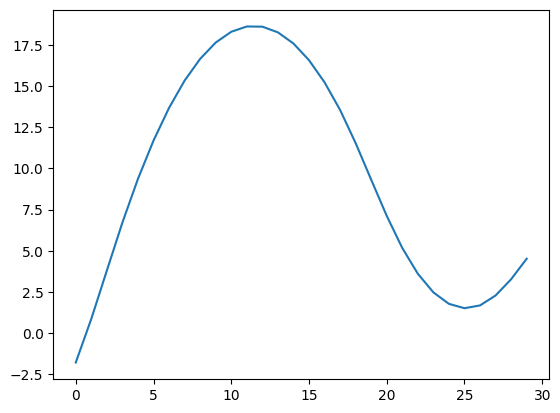

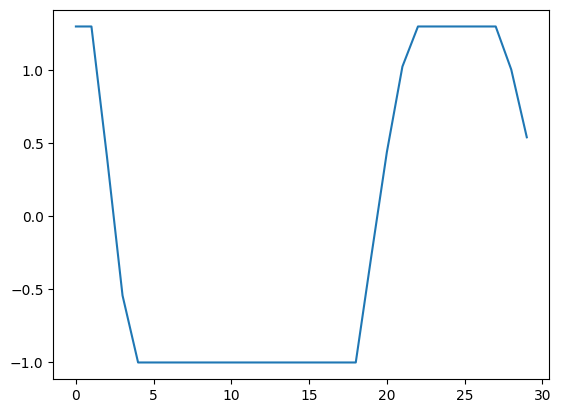

In [81]:
def MPC_controller(x0, x_target, control_dt, m, N):
    x = cs.MX.sym('x', 2) # Two states
    p = cs.MX.sym('p')    # Free parameter

    # RIGHT-HAND SIDE
    rhs = cs.vertcat(x[1],
                     p / m)

    ode = {}
    ode['x']   = x
    ode['p']   = p
    ode['ode'] = rhs

    # INTERGRATOR
    F = cs.integrator('F', 'cvodes', ode, {'tf' : control_dt})

    x = x0
    
    u = cs.MX.sym('u', N, 1)
    
    for k in range(N):
        # Integrate 1s forward in time:
        # call integrator symbolically
        res = F(x0 = x, p = u[k])
        x = res["xf"]

    # NLP declaration
    nlp = {'x' : u, 'f' : cs.dot(x[0] - x_target, x[0] - x_target) +
                          #10 * cs.dot(x[1], x[1]) +
                          1 * cs.dot(u, u)}
    
    opts = {'ipopt.print_level' : 3, 'print_time' : 0,
            'ipopt.max_iter' : 1}

    # Solve using IPOPT
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)
        
    res = solver(x0 = 0.0, lbg = 0, ubg = 0, lbx = -1, ubx = 1.3)
        
    return res['x'][0]

x_far = [-4, 2]

_, _ = simulate_dyn_point(PD_controller, x0 = x_far, step_num = step_num, control_dt = control_dt, m = m)

#_, _ = simulate_dyn_point(MPC_controller, x0 = x_far, step_num = step_num, control_dt = control_dt, m = m)

#_, _ = simulate_dyn_point(MPC_controller, x0 = x0, step_num = step_num, control_dt = control_dt, m = m, N = 5)

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   1.4350615794192528e+01    1.4350615794192528e+01
Dual infeasibility......:   2.6882466857585676e+00    2.6882466857585676e+00
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

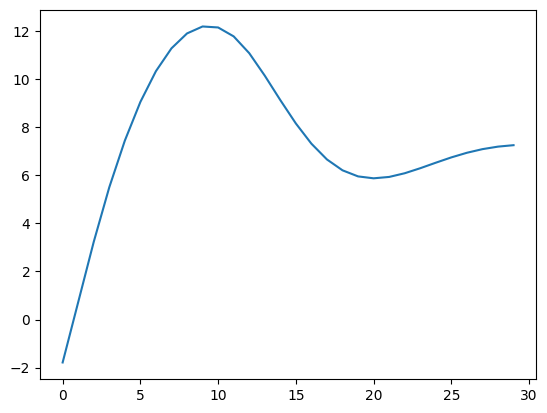

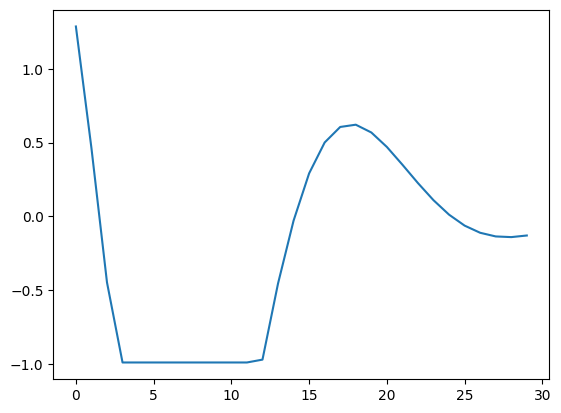

In [82]:
_, _ = simulate_dyn_point(MPC_controller, x0 = x_far, step_num = step_num, control_dt = control_dt, m = m)

In [ ]:
_, _ = simulate_dyn_point(PD_controller, x0 = x_far, step_num = step_num * 5, control_dt = control_dt, m = m)

### Let us start developing Capture Step with a predictive model

In [ ]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np

def simulate_LIPM(x0, footstep_position, g_over_l, t):
    x = cs.MX.sym('x', 2)
    
    ts = np.linspace(0, t, 10)

    rhs = cs.vertcat(x[1],
                     g_over_l * (x[0] - footstep_position))

    ode = {}
    ode['x'] = x
    ode['ode'] = rhs

    #F = cs.integrator('F', 'cvodes', ode, {'tf' : t})
    F = cs.integrator('F', 'cvodes', ode, {'grid' : ts})

    res = F(x0 = x0)

    x = res["xf"]
    
    return x

In [ ]:
def calc_capture_step(x0, g_over_l, t):
    x = cs.MX.sym('x', 2) # Two states
    p = cs.MX.sym('p')    # Free parameter

    rhs = cs.vertcat(x[1],
                     g_over_l * (x[0] - p))

    ode = {}
    ode['x'] = x
    ode['p'] = p
    ode['ode'] = rhs

    ts = np.linspace(0, t, 10)

    x = x0
    
    F = cs.integrator('F', 'cvodes', ode, {'tf' : t})
    #F = cs.integrator('F', 'cvodes', ode, {'grid' : ts})

    u = cs.MX.sym('u', 1, 1)
    
    res = F(x0 = x, p = u)
    
    x = res["xf"]
    
    print(x)

    # NLP declaration
    nlp = {'x' : u, 'f' : cs.dot(x, x)}
    
    opts = {'ipopt.print_level' : 0, 'print_time' : 0,
            'ipopt.max_iter' : 1}

    # Solve using IPOPT
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)
        
    res = solver(x0 = 0.0, lbg = 0, ubg = 0)#, lbx = -1, ubx = 1.3)
        
    optimal_footstep = res['x'][0]

    print("results", optimal_footstep)

    return optimal_footstep

x0 = [0.3, 0.1]

optimal_capture_step = calc_capture_step(x0, 1, 1)

trajectory = simulate_LIPM(x0, optimal_capture_step, 1, 1)

npied = np.array(trajectory)

print(npied[0])

plt.plot(npied[0])
plt.show()
plt.plot(npied[1])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import linalg
import copy
import math

class LIP:
    def __init__(self, m, g, h, dt, x0, xd0, y0, yd0, xleg0, yleg0):
        self.m = m
        self.g = g
        self.h = h
                
        self.dt = dt
        
        self.x = np.array([[x0],
                           [xd0],
                           [y0],
                           [yd0]])
        
        self.xleg = xleg0
        self.yleg = yleg0
        
        self.A = np.array([[0,          1, 0,          0],
                           [self.g / h, 0, 0,          0],
                           [0,          0, 0,          1],
                           [0,          0, self.g / h, 0]])
        
    def get_state(self):
        return self.x, self.xleg, self.yleg
    
    def propagate_system(self):
        xd = self.A @ (self.x - np.array([[self.xleg], [0], [self.yleg], [0]]))
        
        self.x += xd * self.dt
        
    def set_leg_position(self, newx, newy):
        self.xleg = newx
        self.yleg = newy

def calc_footstep_position(x0, x_target, g_over_l, t):
    

    return optimal_footstep

def run_LIP(m, g, h, l, x0, xd0, y0, yd0, dt, iter_num,
            step_time, ref_x, ref_y):
    lip = LIP(m, g, h, dt, x0, xd0, y0, yd0, x0, y0)

    x_traj = []
    y_traj = []
    x_leg_traj = []
    y_leg_traj = []
    
    t = 0
    time_elapsed = 0
    
    for i in range(iter_num - int(step_time / dt)):
        curr_t = dt * i
        
        state, xleg, yleg = lip.get_state()
                
        if (time_elapsed >= step_time):
            time_elapsed = 0
            
            newx = calc_footstep_position([state[0, 0], state[1, 0]], ref_x[i + int(step_time / dt)],
                                          g / l, step_time)
            
            newy = calc_footstep_position([state[2, 0], state[3, 0]], ref_y[i + int(step_time / dt)],
                                          g / l, step_time)
            
            newx = float(newx)
            newy = float(newy)
            
            lip.set_leg_position(newx, newy)
            print("new leg position at t = ", curr_t, " : ", newx, newy)
            
        x_traj.append(state[0, 0])
        y_traj.append(state[2, 0])
        x_leg_traj.append(xleg)
        y_leg_traj.append(yleg)
        
        lip.propagate_system()
        
        time_elapsed += dt
    
    return x_traj, y_traj, x_leg_traj, y_leg_traj

iter_num = 550
h = 1

ref_x, ref_y = [], []

for i in range(iter_num):
    angle1 = i / 100
    angle2 = i / 25
    
    x = np.cos(angle1) * 7 #(7 + 0.18 * np.cos(angle2))
    y = np.sin(angle1) * 7 #(7 + 0.18 * np.cos(angle2))
    
    ref_x.append(x)
    ref_y.append(y)

step_time = 0.7
dt = 0.1

x_hist, y_hist, x_leg_traj, y_leg_traj = run_LIP(m = 1.0,
    g = 10, h = h, l = 1, x0 = ref_x[0] + 0.01, xd0 = 0.004,
    y0 = ref_y[0] + 0.01, yd0 = -0.005,
    dt = dt, iter_num = iter_num, step_time = step_time, ref_x = ref_x,
                                                 ref_y = ref_y)

print("simulation complete")

iter_num -= int(step_time / dt)

plt.plot(np.linspace(0, iter_num, iter_num), x_hist)
plt.plot(np.linspace(0, iter_num, iter_num), ref_x[:iter_num])
plt.show()

plt.plot(x_hist, y_hist)
plt.plot(ref_x, ref_y)
plt.gca().set_aspect('equal')
plt.show()